## Continuous T1 

This reads out the state of the qubit at t = T1 continuously. We recalibrate the qubit after some variable time. The qubit is assumed to be calibrated and the data saved to the cfg file 

# ------------ Initializations ------------

In [2]:
# %matplotlib widget
%matplotlib inline

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
import scipy as sp
import json
import cProfile
import re 
import datetime
from timeit import default_timer as timer

from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict
from datetime import datetime
import h5py


# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickSoc: No module named 'pynq'
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver


In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas


imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.DONOTUSE_ramsey_ef
imported experiments.single_qubit.DONOTUSE_randbench
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy_test
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.SingleRB
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.single_shot_ziqian
imported experiments.single_qubit.t1
imported experiments.single_qubit.t1_2qb
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported exp

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
expt_path=os.getcwd()+'\data'
data_path = "C:\_Data\LLqub_contT1"
print('Continuous T1 Data will be stored in', data_path)
print('SLAB data will be stored in', expt_path) 

Continuous T1 Data will be stored in C:\_Data\LLqub_contT1
SLAB data will be stored in c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data


Import the cfg file: 

In [7]:
import yaml
# Results config file:
results_config_file = 'autocalibration_cfg.yml'
results_config_path = os.getcwd() + '\\' + results_config_file
print('Results config will be', results_config_path)

# open the file 
with open(results_config_file,'r') as file:
  auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

def save_edits( file_name, edit_config, edit_list, qubit_i,  value):
    print('Assumes edit_list is already in edit_config')
    print('If it is not, it will not update edit_config')
    # open the file 
    # edit the file
    edit_list[qubit_i] = value
    # dump it: 
    edit_config= yaml.safe_dump(edit_config.to_dict(), default_flow_style=  True)

    # write it: 
    with open(file_name, 'w') as modified_file:
        modified_file.write(edit_config)

    # now, open the modified file again 
    with open(file_name,'r') as file:
      edit_config=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 
    return edit_config

Results config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\autocalibration_cfg.yml


In [8]:
im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab

soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)
print(auto_cfg['aliases']['soc'])
print(soc.description())



QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_signal_gen_v4 - tProc out

215 307
readout freq 0 +/- 7098.122026730655


  0%|          | 0/1000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00026_adc_trig_offset_calibration_qubit0.h5


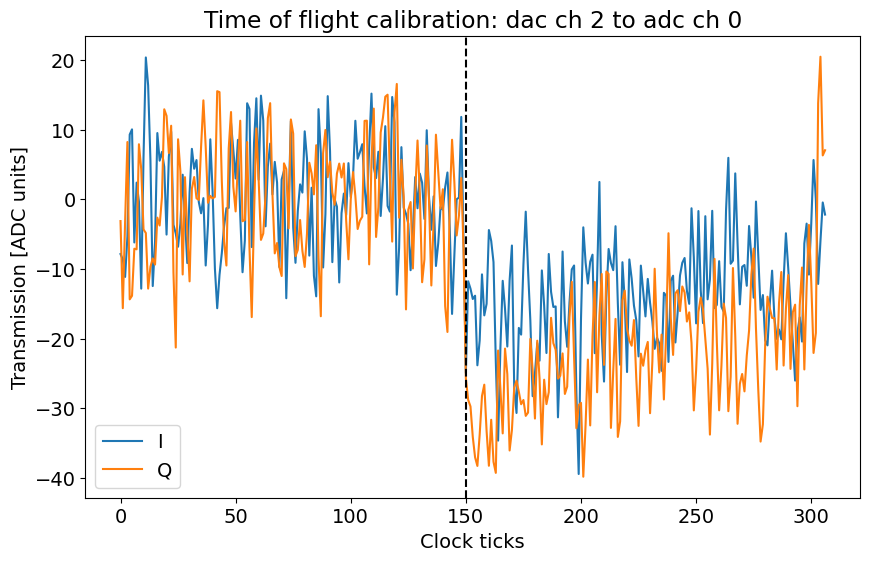

In [9]:
qubit_i = 0
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=results_config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    gain=30000, # blast the power just for the RFSoC calibration
    # gain=5000, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=1000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]

import Pyro4.util
try: 
    tof.go(analyze=False, display=False, progress=True, save=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

tof.display(adc_trig_offset=150) 

## Run the T1 

In [10]:
def run_continuous_t1(qubit_i):
    t1_cont = meas.T1Continuous(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_continuous_qubit{qubit_i}",
        config_file=results_config_path,
    )

    span = auto_cfg.device.qubit.T1[qubit_i]
    npts = 1

    t1_cont.cfg.expt = dict(
        start=span / npts,  # wait time [us]
        step=0,
        expts=npts,
        reps=  1000000, #1000000,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubit=qubit_i,
    )

    t1_cont.go(analyze=False, display=False, progress=True, save=False)
    t1_raw_i = t1_cont.data['raw_i']
    t1_raw_q = t1_cont.data['raw_q']
    t1_amps = t1_cont.data['raw_amps']

    return t1_raw_i, t1_raw_q, t1_amps
pass

def run_t1_recalibration(qubit_i):
    t1 = meas.T1Experiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"t1_qubit{qubit_i}",
        config_file=results_config_path,
        )

    span = 600 
    npts = 100 #100

    t1.cfg.expt = dict(
        start=0,  # wait time [us]
        step=int(span / npts),
        expts=npts,
        reps= 100*5, #100*5,  # number of times we repeat a time point
        rounds=1,  # number of start to finish sweeps to average over
        qubit=qubit_i,
        length_scan=span,  # length of the scan in us
        num_saved_points=1,  # number of points to save for the T1 continuous scan
        )

    t1.go(analyze=False, display=False, progress=True, save=False)
    t1.analyze(fit=True)
    t1_err_i = np.sqrt(t1.data['fit_err_avgi'][3][3])
    t1_fit_i =t1.data['fit_avgi'][3]
    err_ratio_i = t1_err_i/t1_fit_i

    t1_err_q = np.sqrt(t1.data['fit_err_avgq'][3][3])
    t1_fit_q =t1.data['fit_avgq'][3]
    err_ratio_q = t1_err_q/t1_fit_q

    # open the results config file 
    with open(results_config_file,'r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    if err_ratio_i< err_ratio_q:
        print('t1_i is better, saving T1_i to results cfg file') 
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_i)  # [DAC units]  

    else: 
        print('t1_q is better, saving t1_q to results cfg file')
        auto_cfg.device.qubit.T1[qubit_i] = float(t1_fit_q)  # [DAC units]  

    auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

    # write it: 
    with open('autocalibration_cfg.yml', 'w') as modified_file:
        modified_file.write(auto_cfg)
    # now, open the modified file again 
    with open('autocalibration_cfg.yml','r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary
    
    t1_i = t1.data['avgi']
    t1_q = t1.data['avgq']
    t1_amp = t1.data['amps']
    t1_i_value = t1.data['fit_avgi'][3]
    t1_q_value = t1.data['fit_avgq'][3]
    t1_amp_value = t1.data['fit_amps'][3]
    t1_i_value_err = t1.data['fit_err_avgi'][3][3]
    t1_q_value_err = t1.data['fit_err_avgq'][3][3]
    t1_amp_value_err = t1.data['fit_err_amps'][3][3]

    return t1_i, t1_q, t1_amp, t1_i_value, t1_q_value, t1_amp_value, t1_i_value_err, t1_q_value_err, t1_amp_value_err
pass

def run_single_shot(qubit_i):
    shot = meas.HistogramExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"single_shot_qubit{qubit_i}",
        config_file= results_config_path,
    )

    shot.cfg.expt = dict(
        reps=10000,
        check_e = True, 
        check_f=False,
        qubit=0,
    )

    shot.go(analyze=False, display=False, progress=True, save=True)
    shot.analyze(verbose=False)

    rotation_angle = shot.data['angle']
    print(rotation_angle)
    threshold = shot.data['thresholds'][0]
    print(threshold)

    fidelity = shot.data['fids'][0]*100
    Ig = shot.data['Ig']
    Qg = shot.data['Qg']
    Ie = shot.data['Ie']
    Qe = shot.data['Qe']

     # open the results config file 
    with open(results_config_file,'r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    auto_cfg.device.readout.phase[qubit_i] = float(rotation_angle) # degrees
    # auto_cfg.device.readout.threshold[qubit_i] = float(threshold) # [DAC units]

    auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

    # write it: 
    with open('autocalibration_cfg.yml', 'w') as modified_file:
        modified_file.write(auto_cfg)
    # now, open the modified file again 
    with open('autocalibration_cfg.yml','r') as file:
        auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

    return rotation_angle, threshold, fidelity, Ig, Qg, Ie, Qe

def main():
    # Get the current date and time
    import datetime
    current_datetime = datetime.datetime.now()
    formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

    # Create the filename using the formatted date and time
    filename = os.path.join(data_path, f"{formatted_datetime}.h5")

    # Create an HDF5 file to save all the data
    hf = h5py.File(filename, 'a')

    if 't1_cont' not in hf:
        g1 = hf.create_group('t1_cont')
        g1.create_dataset('i', data=np.array([]), maxshape=(None,))
        g1.create_dataset('q', data=np.array([]), maxshape=(None,))
        g1.create_dataset('amp', data=np.array([]), maxshape=(None,))

    if 't1_recal' not in hf:
        g2 = hf.create_group('t1_recal')
        g2.create_dataset('i', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value', data=np.array([]), maxshape=(None,))
        g2.create_dataset('i_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('q_value_err', data=np.array([]), maxshape=(None,))
        g2.create_dataset('amp_value_err', data=np.array([]), maxshape=(None,))
    
    if 'single_shot' not in hf:
        g3 = hf.create_group('single_shot')
        g3.create_dataset('angle', data=np.array([]), maxshape=(None,))
        g3.create_dataset('threshold', data=np.array([]), maxshape=(None,))
        g3.create_dataset('fidelity', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Ig', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Qg', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Ie', data=np.array([]), maxshape=(None,))
        g3.create_dataset('Qe', data=np.array([]), maxshape=(None,))

    qubit_i = 0
    # Initialize arrays
    t1_raw_i_data, t1_raw_q_data, t1_amps_data = np.array([]), np.array([]), np.array([])
    
    t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err= np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])  

    angle_recal, threshold_recal, fidelity_recal, Ig_recal, Qg_recal, Ie_recal, Qe_recal = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    start_time = timer()
    try:
        while True:
            # Run the continuous T1 experiment
            t1_raw_i_data, t1_raw_q_data, t1_amps_data = run_continuous_t1(qubit_i)

            # Append new data to datasets
            hf['t1_cont/i'].resize((hf['t1_cont/i'].shape[0] + t1_raw_i_data.shape[0]), axis=0)
            hf['t1_cont/i'][-t1_raw_i_data.shape[0]:] = t1_raw_i_data

            hf['t1_cont/q'].resize((hf['t1_cont/q'].shape[0] + t1_raw_q_data.shape[0]), axis=0)
            hf['t1_cont/q'][-t1_raw_q_data.shape[0]:] = t1_raw_q_data

            hf['t1_cont/amp'].resize((hf['t1_cont/amp'].shape[0] + t1_amps_data.shape[0]), axis=0)
            hf['t1_cont/amp'][-t1_amps_data.shape[0]:] = t1_amps_data
           
            print('Continuous data appended to', filename)

            end_time = timer()

            if end_time - start_time >= 60*30: #60*30
                print(f"{end_time - start_time} seconds have passed. Running T1 recalibration.")

                # Run the T1 recalibration experiment
                t1_i_recal_data, t1_q_recal_data, t1_amp_recal_data, t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data, t1_i_value_recal_data_err, t1_q_value_recal_data_err, t1_amp_value_recal_data_err = run_t1_recalibration(qubit_i)

                print(t1_i_value_recal_data, t1_q_value_recal_data, t1_amp_value_recal_data)

                print(np.shape(t1_i_value_recal_data), np.shape(t1_q_value_recal_data), np.shape(t1_amp_value_recal_data))
                hf['t1_recal/i'].resize((hf['t1_recal/i'].shape[0] + t1_i_recal_data.shape[0]), axis=0)
                hf['t1_recal/i'][-t1_i_recal_data.shape[0]:] = t1_i_recal_data

                hf['t1_recal/q'].resize((hf['t1_recal/q'].shape[0] + t1_q_recal_data.shape[0]), axis=0)
                hf['t1_recal/q'][-t1_q_recal_data.shape[0]:] = t1_q_recal_data

                hf['t1_recal/amp'].resize((hf['t1_recal/amp'].shape[0] + t1_amp_recal_data.shape[0]), axis=0)
                hf['t1_recal/amp'][-t1_amp_recal_data.shape[0]:] = t1_amp_recal_data

                # T1 values for I, Q, and amp: 
                hf['t1_recal/i_value'].resize((hf['t1_recal/i_value'].shape[0] + 1), axis=0)
                hf['t1_recal/i_value'][-1:] = t1_i_value_recal_data

                hf['t1_recal/q_value'].resize((hf['t1_recal/q_value'].shape[0] + 1), axis=0)
                hf['t1_recal/q_value'][-1:] = t1_q_value_recal_data

                hf['t1_recal/amp_value'].resize((hf['t1_recal/amp_value'].shape[0] + 1), axis=0)
                hf['t1_recal/amp_value'][-1:] = t1_amp_value_recal_data

                # T1 errors for I, Q, and amp:  
                hf['t1_recal/i_value_err'].resize((hf['t1_recal/i_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/i_value_err'][-1:] = t1_i_value_recal_data_err

                hf['t1_recal/q_value_err'].resize((hf['t1_recal/q_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/q_value_err'][-1:] = t1_q_value_recal_data_err

                hf['t1_recal/amp_value_err'].resize((hf['t1_recal/amp_value_err'].shape[0] + 1), axis=0)
                hf['t1_recal/amp_value_err'][-1:] = t1_amp_value_recal_data_err

                # Run the single shot recalibration 
                angle_recal, threshold_recal, fidelity_recal, Ig_recal, Qg_recal, Ie_recal, Qe_recal  = run_single_shot(qubit_i)

                hf['single_shot/angle'].resize((hf['single_shot/angle'].shape[0] + 1), axis=0)
                hf['single_shot/angle'][-1:] = angle_recal
                hf['single_shot/threshold'].resize((hf['single_shot/threshold'].shape[0] + 1), axis=0)
                hf['single_shot/threshold'][-1:] = threshold_recal
                hf['single_shot/fidelity'].resize((hf['single_shot/fidelity'].shape[0] + 1), axis=0)
                hf['single_shot/fidelity'][-1:] = fidelity_recal
                print('new anle, threshold, and fidelity', angle_recal, threshold_recal, fidelity_recal)
                
                # I and Q values for shots
                hf['single_shot/Ig'].resize((hf['single_shot/Ig'].shape[0] + Ig_recal.shape[0]), axis=0)
                hf['single_shot/Ig'][-Ig_recal.shape[0]:] = Ig_recal

                hf['single_shot/Qg'].resize((hf['single_shot/Qg'].shape[0] + Qg_recal.shape[0]), axis=0)
                hf['single_shot/Qg'][-Qg_recal.shape[0]:] = Qg_recal

                hf['single_shot/Ie'].resize((hf['single_shot/Ie'].shape[0] + Ie_recal.shape[0]), axis=0)
                hf['single_shot/Ie'][-Ie_recal.shape[0]:] = Ie_recal

                hf['single_shot/Qe'].resize((hf['single_shot/Qe'].shape[0] + Qe_recal.shape[0]), axis=0)
                hf['single_shot/Qe'][-Qe_recal.shape[0]:] = Qe_recal

                print('Recalibration data appended to', filename)
                start_time = timer()  # Reset the start time

    except KeyboardInterrupt:
        # If KeyboardInterrupt (Ctrl+C) is detected, close the HDF5 file
        hf.close()
        print("Program stopped. HDF5 file closed.")
 
if __name__ == "__main__":
    main()


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3343.874548599997 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
220.40481218292945 236.3653626484178 219.90913643476676
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00052_single_shot_qubit0.h5
153.98225207661204
8.276742685489621
new anle, threshold, and fidelity 153.98225207661204 8.276742685489621 82.17410870543527
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.5584412000026 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
105.06693032047717 108.34735710057778 107.0047470190588
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00053_single_shot_qubit0.h5
151.5290691976432
9.375438205481078
new anle, threshold, and fidelity 151.5290691976432 9.375438205481078 85.25426271313566
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3343.394994199989 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
206.81046997837677 187.7648193510022 189.57099831358408
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00054_single_shot_qubit0.h5
149.31170428674972
8.70858652891612
new anle, threshold, and fidelity 149.31170428674972 8.70858652891612 86.76433821691084
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.7954862000042 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
197.78230653444373 200.44602589157705 197.4688947598372
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00055_single_shot_qubit0.h5
146.77351843939397
9.134691334296118
new anle, threshold, and fidelity 146.77351843939397 9.134691334296118 85.6742837141857
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.7656456999975 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
150.15380360004798 151.25048108267984 149.435992727033
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00056_single_shot_qubit0.h5
144.62516611343852
9.249936935551325
new anle, threshold, and fidelity 144.62516611343852 9.249936935551325 85.98429921496074
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.7830104999884 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
153.62030705492327 186.3117122951013 184.04999508505537
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00057_single_shot_qubit0.h5
141.90264604103487
8.860347542816964
new anle, threshold, and fidelity 141.90264604103487 8.860347542816964 84.92849284928494
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.102097799987 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
207.4266765705161 184.45175330782683 182.29036851005932
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00058_single_shot_qubit0.h5
140.5548829209594
9.379635384264459
new anle, threshold, and fidelity 140.5548829209594 9.379635384264459 86.92869286928693
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.0891375999927 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
154.11268726231475 156.8269563126739 155.2823437705167
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00059_single_shot_qubit0.h5
138.34217264271604
9.206358340471471
new anle, threshold, and fidelity 138.34217264271604 9.206358340471471 86.23431171558578
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.0861946000077 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
186.8713794819826 108.71679806723343 107.53769147055105
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00060_single_shot_qubit0.h5
138.04637306542273
9.308867951826446
new anle, threshold, and fidelity 138.04637306542273 9.308867951826446 84.73423671183559
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3343.804700000008 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
144.10870278754263 216.53035311754547 213.82938769757868
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00061_single_shot_qubit0.h5
137.39863717921614
8.324023528759138
new anle, threshold, and fidelity 137.39863717921614 8.324023528759138 79.02790279027903
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.3068058000063 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
117.0531518895029 128.26192864504907 127.32896240038464
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00062_single_shot_qubit0.h5
136.7660577526172
9.775738114605051
new anle, threshold, and fidelity 136.7660577526172 9.775738114605051 85.02425121256063
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3343.6052111000026 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
92.05039017963654 154.89515565004385 153.28967565150103
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00063_single_shot_qubit0.h5
137.21075501033025
8.625691789249036
new anle, threshold, and fidelity 137.21075501033025 8.625691789249036 83.45251787768166
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.7701658000005 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
266.40305800882425 231.32645158462378 227.1111279780414
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00064_single_shot_qubit0.h5
138.4396446730141
8.835887449821401
new anle, threshold, and fidelity 138.4396446730141 8.835887449821401 80.8340417020851
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.321939600006 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
35.724365110064625 35.613489661231625 35.28482888102336
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00065_single_shot_qubit0.h5
137.36136920483295
8.769549321409995
new anle, threshold, and fidelity 137.36136920483295 8.769549321409995 84.35421771088555
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.6220045999944 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
115.36530328990756 108.05880218549632 106.68227366239161
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00066_single_shot_qubit0.h5
139.05562777232612
9.094896289759403
new anle, threshold, and fidelity 139.05562777232612 9.094896289759403 83.53417670883545
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.855566099999 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
113.94984399172861 109.7197173342243 109.31278470790798
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00067_single_shot_qubit0.h5
140.326608141419
8.488206586369133
new anle, threshold, and fidelity 140.326608141419 8.488206586369133 84.21421071053553
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3343.4116629999917 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
213.09156315906836 237.86226117094748 232.24953535804053
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00068_single_shot_qubit0.h5
142.07912387739978
8.476592042440942
new anle, threshold, and fidelity 142.07912387739978 8.476592042440942 85.33426671333567
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3343.4023767000035 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
90437.4791937512 2032.0778760541536 1428.550809356724
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00069_single_shot_qubit0.h5
144.6139263013169
8.665912448587374
new anle, threshold, and fidelity 144.6139263013169 8.665912448587374 82.83828382838284
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3343.7137895999767 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
331.88482485919513 330.1594659912558 319.58708498123565
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00070_single_shot_qubit0.h5
147.467490048941
8.227831052260713
new anle, threshold, and fidelity 147.467490048941 8.227831052260713 78.26391319565978
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3343.656012499996 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_i is better, saving T1_i to results cfg file
295.8756009292971 341.87701910494724 327.1017293935413
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00071_single_shot_qubit0.h5
149.42547433243402
8.1618058166646
new anle, threshold, and fidelity 149.42547433243402 8.1618058166646 77.38386919345967
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.10538730002 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
371.44647523347163 337.3748034053751 332.83860958179855
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00072_single_shot_qubit0.h5
150.59089159982105
9.489391769459367
new anle, threshold, and fidelity 150.59089159982105 9.489391769459367 79.90399519975999
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Continuous data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5
3344.847624099988 seconds have passed. Running T1 recalibration.


  0%|          | 0/50000 [00:00<?, ?it/s]

t1_q is better, saving t1_q to results cfg file
165.01819901523697 173.36123466572687 170.32718913825232
() () ()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\data\00073_single_shot_qubit0.h5
149.52075829615342
8.49765436992016
new anle, threshold, and fidelity 149.52075829615342 8.49765436992016 85.20852085208521
Recalibration data appended to C:\_Data\LLqub_contT1\2024-02-28_19-53-47.h5


  0%|          | 0/1000000 [00:00<?, ?it/s]

Program stopped. HDF5 file closed.


In [37]:
with open(results_config_file,'r') as file:
    auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

auto_cfg.device.readout.phase[qubit_i] = -7.844325608133489 # degrees
auto_cfg.device.readout.threshold[qubit_i] = 57.221847452942725 # [DAC units]

auto_cfg= yaml.safe_dump(auto_cfg.to_dict(), default_flow_style=  True) # dump it 

# write it: 
with open('autocalibration_cfg.yml', 'w') as modified_file:
    modified_file.write(auto_cfg)
# now, open the modified file again 
with open('autocalibration_cfg.yml','r') as file:
    auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary

In [ ]:
import yaml

# Results config file:
results_config_file = 'autocalibration_cfg.yml'
results_config_path = os.getcwd() + '\\' + results_config_file
print('Results config will be', results_config_path)

# open the file 
with open(results_config_file,'r') as file:
  auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

Results config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\autocalibration_cfg.yml


In [ ]:
import yaml

# Results config file:
results_config_file = 'autocalibration_cfg.yml'
results_config_path = os.getcwd() + '\\' + results_config_file
print('Results config will be', results_config_path)

# open the file 
with open(results_config_file,'r') as file:
  auto_cfg=AttrDict(yaml.safe_load(file)) # turn it into an attribute dictionary 

Results config will be c:\_Lib\python\rfsoc\elaine_rfsoc\slab_rfsoc_expts\autocalibration_cfg.yml
